# Introduction

This project's objective is aligned with the 2023 Kidney and Kidney Tumor Segmentation Challenge.- https://kits-challenge.org/kits23/ The project aims to automate kidney tumor surveillance through an image segmentation system, addressing challenges in accurately monitoring tumor development. Distinct features of kidney tumors in CT images offer valuable insights for treatment studies.

The project explicitly focuses on experimenting with existing image segmentation models, including those commonly used in 2D spatial multi-class image segmentation and advanced 3D volumetric multi-class image segmentation. Furthermore, it employs various techniques such as pre-processing, applying pre-trained weights, fine-tuning hyperparameters, and replacing network layers to enhance these existing models. The project aims to identify limitations, suggesting feasibility for further improvement.

## Motivation

The current manual process is labor-intensive and subjective. The innovative approach involves experimental image segmentation, encompassing data preprocessing and fine-tuning, to reduce labor intensity. This aims to enable early detection and precise diagnosis, enhancing the efficiency of differentiating between malignant and benign tumors.

# Imports python modules
- below gives list of modules used

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import sys
import re
import os
import torch.optim as optim
import time
import nibabel as nib
import matplotlib.pylab as plt
import math
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy import ndimage
from datetime import datetime
from glob import glob

In [2]:
# Let's see whether Nilearn is installed
try:
    import nilearn
except ImportError:
    # if not, install it using pip
    !pip install nilearn
from nilearn.image import resample_img

In [3]:
# !pip install onnx

In [4]:
base_dir = "./"
raw_dataset_dir = "dataset/"
transformed_dataset_dir_path = "dataset/affine_transformed/"

## Dataset folder setup check
- below is to check if dataset folder and preprocessed dataset folder exists

In [5]:
is_colab = True
if is_colab:
    base_dir = "/content/drive/MyDrive/Colab Notebooks/"
    if not os.path.isdir(base_dir):
        from google.colab import drive
        drive.mount('/content/drive')

raw_dataset_dir = os.path.join(base_dir, raw_dataset_dir)
transformed_dataset_dir_path = os.path.join(base_dir, transformed_dataset_dir_path)

if os.path.isdir(raw_dataset_dir) and os.path.isdir(transformed_dataset_dir_path):
    print("dataset folder exists, OK")
else:
    raise Exception("check path for dataset:{} \n path for transformed dataset: {}"
                    .format(raw_dataset_dir, transformed_dataset_dir_path))




dataset folder exists, OK


# Data Sources
- Data sources is for Kits-23 challenge and information can be found at https://kits-challenge.org/.
- Dataset can be downloaded as tar and extract at dataset folder.
- Note: Data is required at dataset folder to enable
-- the view of dataset (visualisation of dataset)
-- pre-process / transform the dataset (to smaller sze)



In [6]:
raw_train_images_path = os.path.join(raw_dataset_dir,'case_00???/imaging.nii.gz')
raw_segmentation_images_path = os.path.join(raw_dataset_dir,'case_00???/segmentation.nii.gz')
raw_train_images = sorted(glob(raw_train_images_path))
raw_segmentation_images = sorted(glob(raw_segmentation_images_path))

if len(raw_train_images) > 2 and len(raw_segmentation_images) > 2:
    print("data exists, OK")
else:
    raise Exception("No data is found at dataset folder {} or segmentation folder {}".format(train_images_path,segmentation_images_path))

data exists, OK


## Challenges
- The images are stored in "nii.gz" format. The size of the images are large and hard to process.
- There are 489 cases availble. These cases have segmented data available. Relatively, large amount of dataset is available.
- Need to understand basic shape of the data
- The number of classes in the dataset need to be verified.


### Visulisation of Dataset
 Get the shape of the images to understand how the 3D images are stored
-It is found that(layers, pixels, pixels) or known as (z, y, x):
- For case 0: (611, 512, 512)
- For case 2: (261, 512, 512)
> 3D cases have different layers!!


In [7]:
case_index = 0
case_index2 = 2
img_path = raw_train_images[case_index]
img_loader = nib.load(img_path)
img = img_loader.get_fdata()
print("index={}, path= {} \n shape of image = {} with type {}\n"
      .format(case_index, img_path, img.shape, type(img)))

img_path2 = raw_train_images[case_index2]
img2_loader = nib.load(img_path2)
img2 = img2_loader.get_fdata()
print("index={}, path= {} \n shape of image = {} with type {}"
      .format(case_index2, img_path, img2.shape, type(img2)))

index=0, path= /content/drive/MyDrive/Colab Notebooks/dataset/case_00000/imaging.nii.gz 
 shape of image = (611, 512, 512) with type <class 'numpy.ndarray'>

index=2, path= /content/drive/MyDrive/Colab Notebooks/dataset/case_00000/imaging.nii.gz 
 shape of image = (261, 512, 512) with type <class 'numpy.ndarray'>



#### Plot the Layers of Case 0




In [8]:
square_num = 6
factor = img.shape[0] // (square_num**2)
print("number of layers to be shown = {}".format(square_num**2))

number of layers to be shown = 36


In [9]:
plt.style.use('default')
fig, axes = plt.subplots(square_num,square_num, figsize=(25,25))
for i, ax in enumerate(axes.reshape(-1)):
    ax.title.set_text(f'Layer {i*factor}')
    ax.imshow(img[i*factor,:,:],cmap="gray")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Check Segmentation Layers
- This is to check how classes are labeled and/or captured. From kits23 challeges, it is known that classes are Kidney, Tumor and Cyst.
- As below is to view 3D Images in planer view, it could fail to show label that is only appears at few layers.
- Numpy unique is used to check clasess/labels.

In [10]:
seg_img_path= raw_segmentation_images[case_index]
seg_img = nib.load(seg_img_path).get_fdata()
seg_img_path2= raw_segmentation_images[case_index2]
seg_img2 = nib.load(seg_img_path2).get_fdata()
print("index={} shape of image = {} with type {}".format(case_index, seg_img.shape, type(seg_img)))
print("index={} shape of image = {} with type {}".format(case_index2, seg_img2.shape, type(seg_img2)))

index=0 shape of image = (611, 512, 512) with type <class 'numpy.ndarray'>
index=2 shape of image = (261, 512, 512) with type <class 'numpy.ndarray'>


#### Determine Classes in Segmentation Layers
- From context, it is known to be segmented to 4 classes, which are Kidney, Cyst and Tumor
- Kidney = 1
- Tumor = 2
- Cyst = 3
- None of above = 0

In [11]:
print("Index={}, seg_path={} \nClass labels = {} ".format(case_index, seg_img_path, np.unique(seg_img)))
print("\n")
print("Index={}, seg_path={} \nClass labels = {} ".format(case_index2, seg_img_path2, np.unique(seg_img2)))

Index=0, seg_path=/content/drive/MyDrive/Colab Notebooks/dataset/case_00000/segmentation.nii.gz 
Class labels = [0. 1. 2.] 


Index=2, seg_path=/content/drive/MyDrive/Colab Notebooks/dataset/case_00002/segmentation.nii.gz 
Class labels = [0. 1. 2. 3.] 


#### Case_00000 and case_000002
- From [Kits-23 Challenge](http://kits-challenge.org) , the dataset information confirms the labels for both cases, where case_00000 has no Cyst, label 3.
- ![alt AFFINE MATRIX](https://github.com/choral/COMP9444_keen_beans/blob/main/notebook_imgs/case_00000_case_00002.png?raw=1)

#### Show Image of Kidney label
- At last step, it demonstrates that case 0 has no Cyst label
- Kidneys are large and can be found at many layers

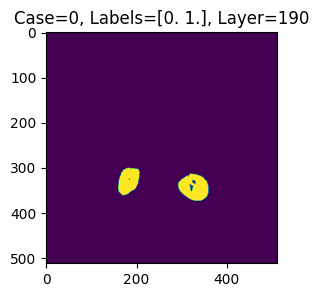

In [12]:
this_layer = 190
plt.style.use('default')
fig, axes = plt.subplots(figsize=(3,3))
axes.imshow(seg_img[this_layer,:,:])
axes.set_title(f"Case={case_index}, Labels={np.unique(seg_img[190,:,:])}, Layer={this_layer}")
plt.show()

#### Inspecting Segmentation Imagers Layers and Labels (for Tumor)
- below is to confirm tumor label exists in the dataset.

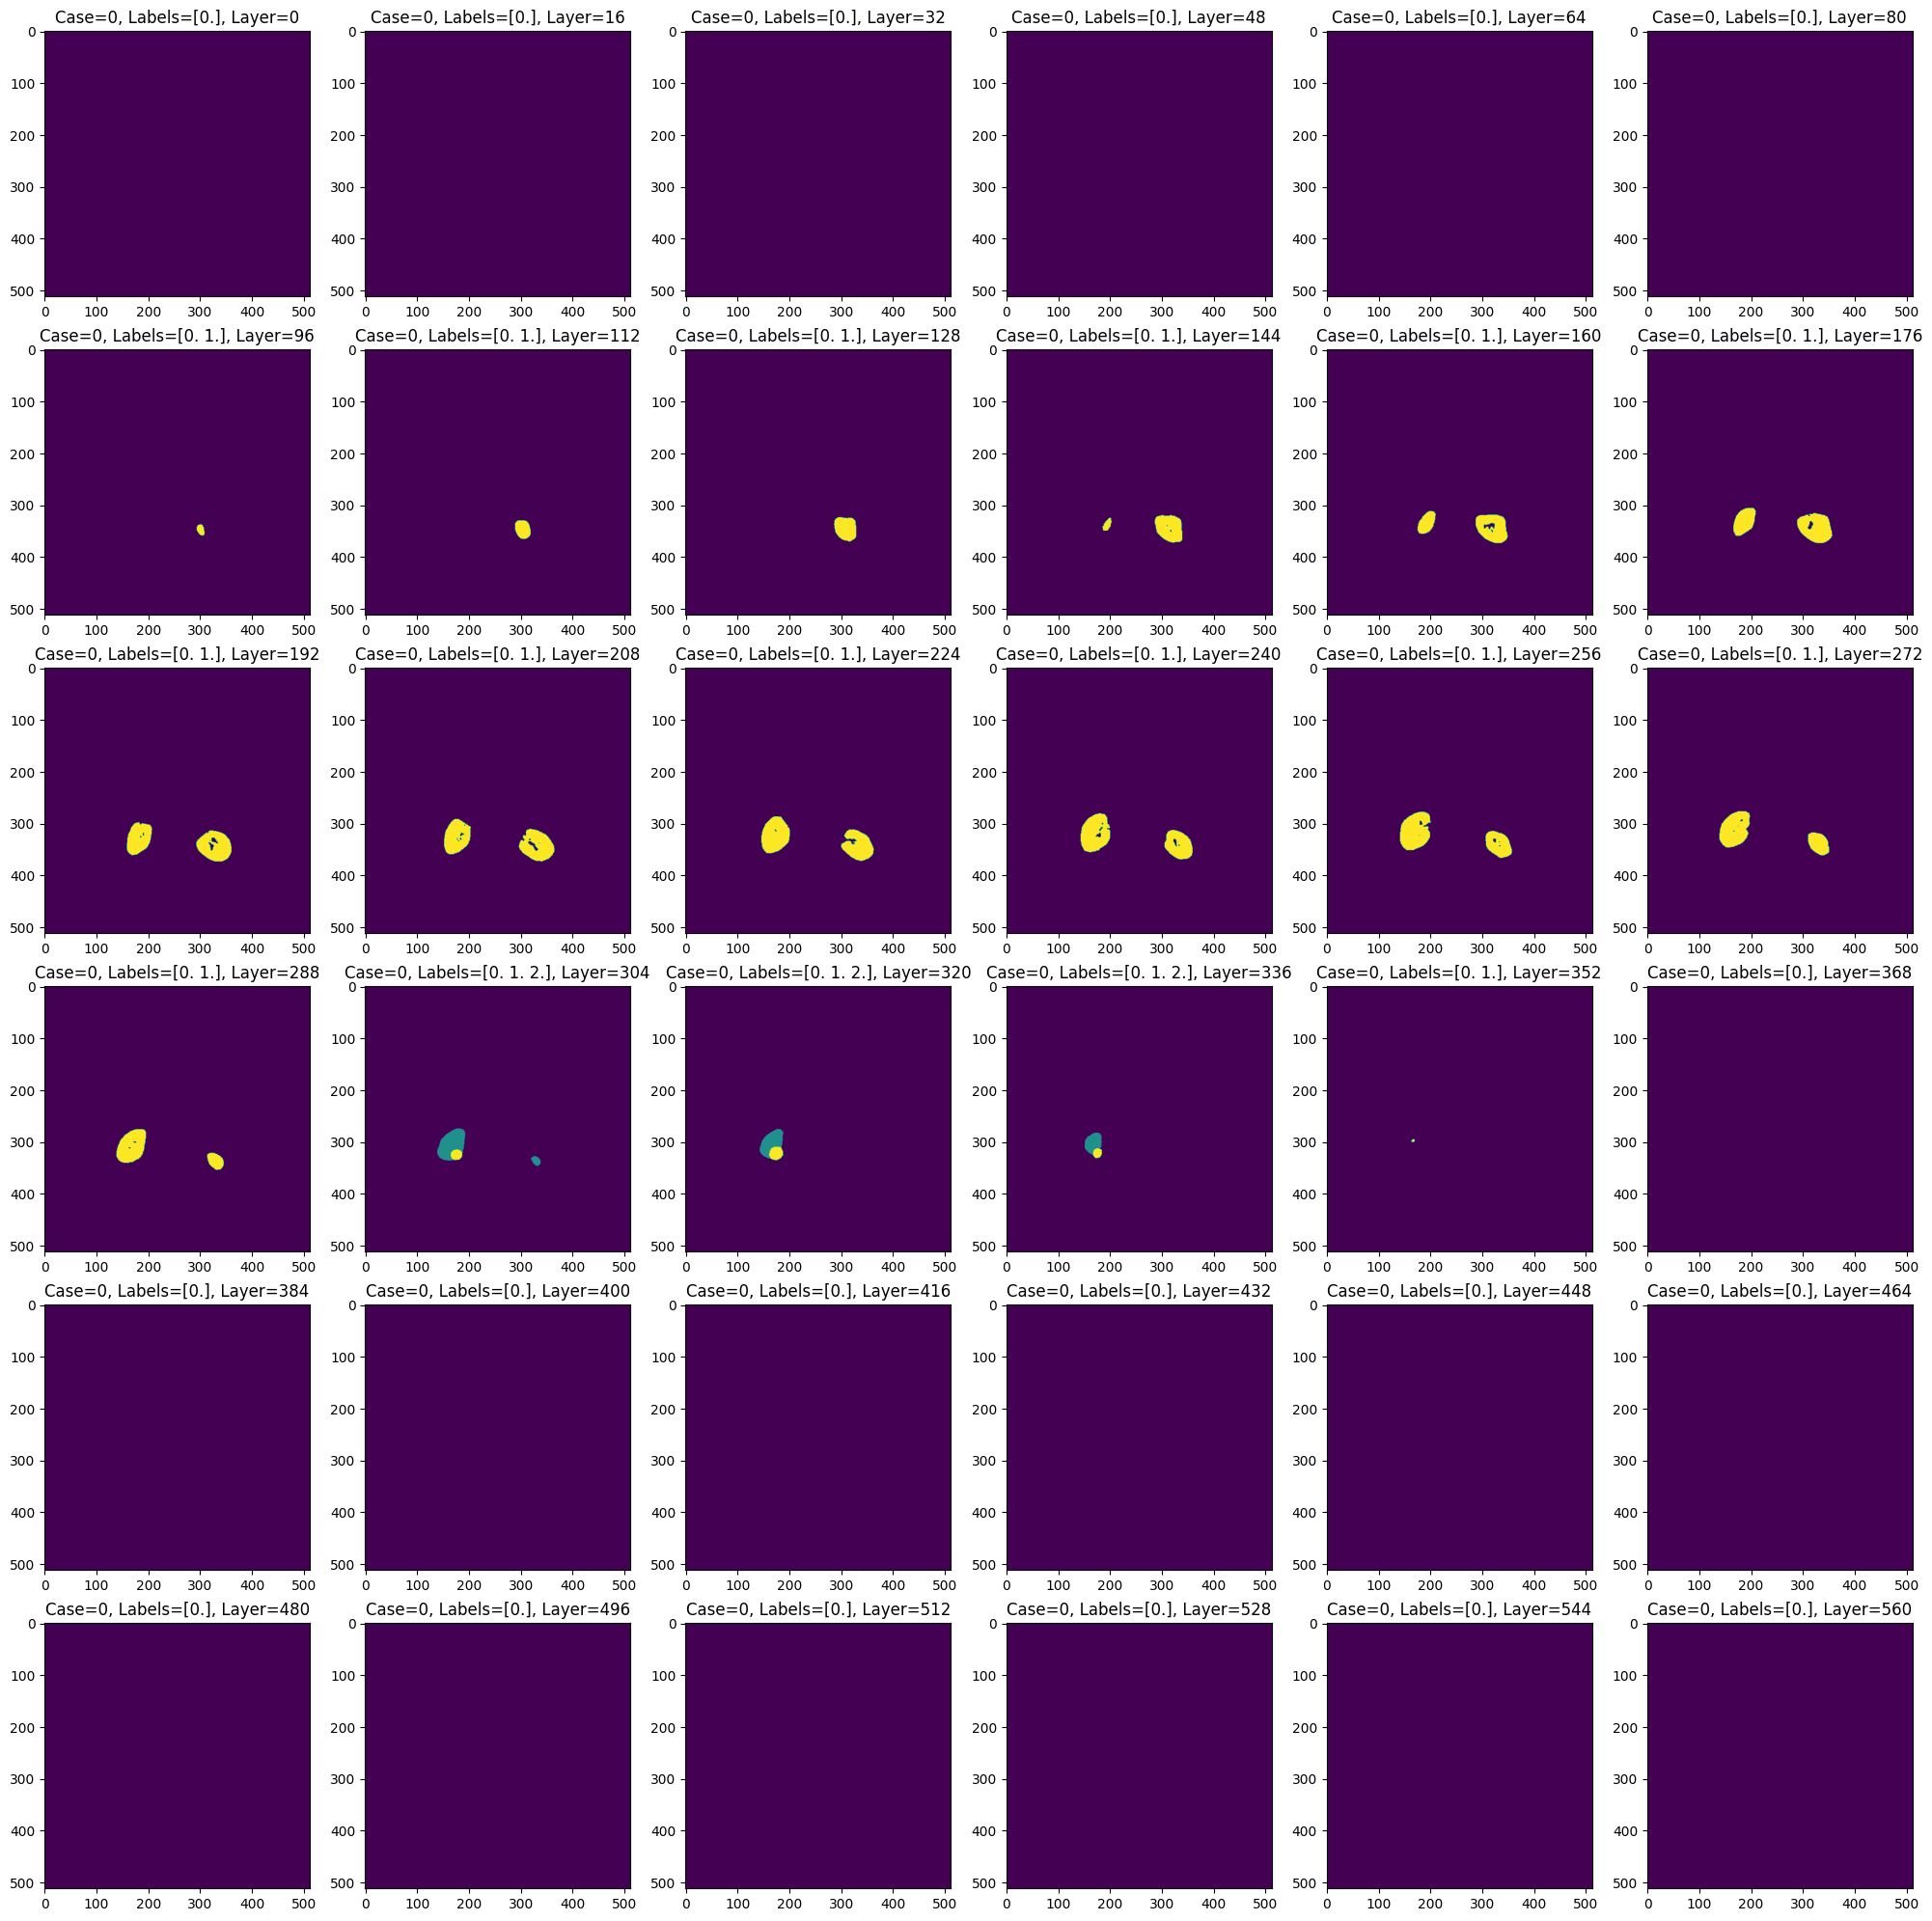

In [13]:
plt.style.use('default')
fig, axes = plt.subplots(square_num,square_num, figsize=(25,25))
for i, ax in enumerate(axes.reshape(-1)):
    this_layer = i*factor
    ax.title.set_text(f"Case={case_index}, Labels={np.unique(seg_img[this_layer,:,:])}, Layer={this_layer}")
    ax.imshow(seg_img[i*factor,:,:])
plt.show()

## Preprocess
- Case visualisation determines that each case or each 3D-images has different number layers.
- These raw dataset are required to transform the 3D-images to uniform dataset.
- Also, due to limitation on computation power and time, it is preferbly to reduce resolution of the 3D-images.
- Strategies that have been adapted are image padding, image clipping and affine transform


### Image padding
- When padding is required for input images, -1024 will be assigned for the padding of the voxel space. This is because the minimum value for the voxel space is -1024.
- For segmentation images, padding value of 0, which represents the background, will be assigned.



### Image clipping
- Voxel space that is not within target shape is clipped. More information can be found at below.

-- https://nilearn.github.io/dev/modules/generated/nilearn.image.resample_img.html#nilearn.image.resample_img

### Affine Transform
- By inspection of data, it has been found that 3D images have different affine setting.
- Due to different in Voxel Spacing, data is transformed to uniform space.
- Also, to reduce the 3D images resolution, it is determined that 3D images are required to be scaled up.
- This can also be described that dataset has different affine setting.



#### Affine Matrix
- Below give general information about affine matrix for 3D volume/perspective transformation.
- It is important to note that dataset used in this project has matrix represented in (z, y, x).
- ![alt AFFINE MATRIX](./notebook_imgs/affine_img.png "Title")

### Inspect affine matrix
- For example, below is to compare case 0 and case 2. Voxel spacing of case 0 is smaller than 2, especially in the z layer, which are 0.5 and 1 respectively.
- To save space, higher voxel spacing is to be used. In Kit19, from https://github.com/jchen42703/kits19-cnn/tree/master, has used target_spacing=(3.22, 1.62, 1.62),
- This project has used target_spacing=(2, 2, 2)

In [14]:
target_affine_space = np.array(([0, 0, -2, 0],[0, -2, 0, 0],[-2, 0, 0, 0],[0, 0, 0, 1]))
target_shape = (128, 232, 232)

In [15]:
case0 = 0
case2 = 2
raw_img_case0_loader = nib.load(raw_train_images[case0])
raw_img_case2_loader = nib.load(raw_train_images[case2])
print("Raw form -> case {} with shape {} has affine: \n{}".format(case0, raw_img_case0_loader.shape, raw_img_case0_loader.affine))
print("Raw form -> case {} with shape {} has affine: \n{}".format(case2, raw_img_case2_loader.shape, raw_img_case2_loader.affine))
resampled_case0_loader = resample_img(raw_img_case0_loader, target_affine=target_affine_space, target_shape=target_shape, interpolation='nearest', fill_value=-1024)
resampled_case2_loader = resample_img(raw_img_case2_loader, target_affine=target_affine_space, target_shape=target_shape, interpolation='nearest', fill_value=-1024)
print("After transform -> case {} with shape {} has affine: \n{}".format(case0,resampled_case0_loader.shape, resampled_case0_loader.affine))
print("After transform -> case {} with shape {} has affine: \n{}".format(case2, resampled_case2_loader.shape, resampled_case2_loader.affine))

Raw form -> case 0 with shape (611, 512, 512) has affine: 
[[ 0.          0.         -0.91992188  0.        ]
 [ 0.         -0.91992188  0.          0.        ]
 [-0.5         0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
Raw form -> case 2 with shape (261, 512, 512) has affine: 
[[ 0.          0.         -0.93945312  0.        ]
 [ 0.         -0.93945312  0.          0.        ]
 [-1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
After transform -> case 0 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]
After transform -> case 2 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


In [16]:
img_case0 = raw_img_case0_loader.get_fdata()
img_case0_resampled = resampled_case0_loader.get_fdata()
img_case2 = raw_img_case2_loader.get_fdata()
img_case2_resampled = resampled_case2_loader.get_fdata()

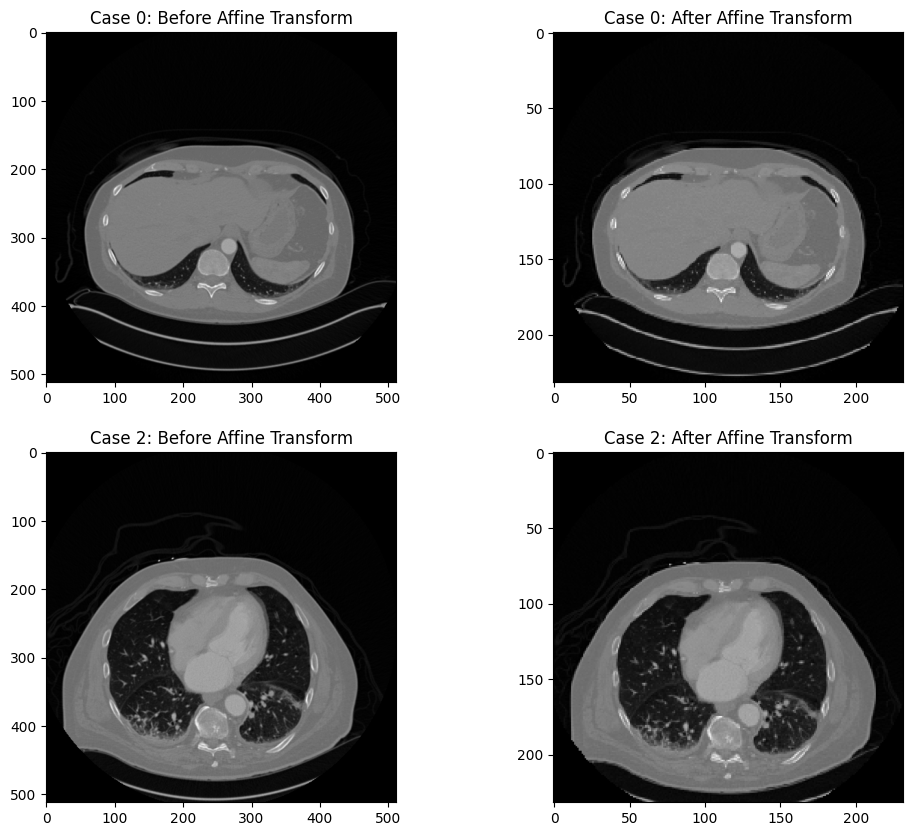

In [17]:
this_layer = 0
plt.style.use('default')
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes[0,0].imshow(img_case0[this_layer,:,:], cmap="gray")
axes[0,0].title.set_text(f'Case {case0}: Before Affine Transform')
axes[0,1].imshow(img_case0_resampled[this_layer,:,:], cmap="gray")
axes[0,1].title.set_text(f'Case {case0}: After Affine Transform')
axes[1,0].imshow(img_case2[this_layer,:,:], cmap="gray")
axes[1,0].title.set_text(f'Case {case2}: Before Affine Transform')
axes[1,1].imshow(img_case2_resampled[this_layer,:,:], cmap="gray")
axes[1,1].title.set_text(f'Case {case2}: After Affine Transform')
# axe.set_title(f"Case={case_index}, Labels={np.unique(seg_img[190,:,:])}, Layer={this_layer}")
plt.show()

### Loss of Segmentation Data from scaling/downsample (Data Augmentation)
The root cause of losing segmentaiton are given at below
- With the chosen affine matrix, some 3D images may scale down or zoom out.
- In addition, the 3D space is to be adapted with lower resolution
- Data augmentation is topic to be considered in the future.

Below has given case 8, that has lost segmentation labels after affine transform. It scale down in z layer, and scale up in x and y axes.

In [18]:
images_path = os.path.join(transformed_dataset_dir_path,'case_00???/segmentation.nii.gz')
segmentation_images_path = os.path.join(transformed_dataset_dir_path,'case_00???/segmentation.nii.gz')
train_images = sorted(glob(images_path))
segmentation_images = sorted(glob(segmentation_images_path))


In [19]:
for i in range(7,9):
    raw_seg_image_path_uniq = raw_segmentation_images[i]
    seg_img_path_uniq = segmentation_images[i]
    seg_img_uniq_loader = nib.load(seg_img_path_uniq)
    raw_seg_img_uniq_loader = nib.load(raw_seg_image_path_uniq)
    seg_img_uniq = seg_img_uniq_loader.get_fdata()
    raw_seg_img_uniq = raw_seg_img_uniq_loader.get_fdata()

    print("Raw case {}, unique={}".format(i, np.unique(raw_seg_img_uniq)))
    print("Transformed case {}, unique={}".format(i, np.unique(seg_img_uniq)))
    print("Raw case 0 with shape {} has affine: \n{}".format(raw_seg_img_uniq_loader.shape, raw_seg_img_uniq_loader.affine))
    print("Transformed case 0 with shape {} has affine: \n{}".format(seg_img_uniq_loader.shape, seg_img_uniq_loader.affine))

    print("==="*10)

Raw case 7, unique=[0. 1. 2.]
Transformed case 7, unique=[0. 1. 2.]
Raw case 0 with shape (61, 512, 512) has affine: 
[[ 0.          0.         -0.93945312  0.        ]
 [ 0.         -0.93945312  0.          0.        ]
 [-3.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
Transformed case 0 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]
Raw case 8, unique=[0. 1. 2. 3.]
Transformed case 8, unique=[0.]
Raw case 0 with shape (227, 512, 512) has affine: 
[[ 0.          0.         -0.81640625  0.        ]
 [ 0.         -0.81640625  0.          0.        ]
 [-3.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
Transformed case 0 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


### Preprocess to transform all dataset to target affine space
- This enable consistent voxel space for analysis
- In general, voxel space is downsampled, this will save process time.
- See notebook <mark>resample_dataset.ipynb</mark>, which is used to resample all dataset

### Free up memory for this lengthy notebook

In [20]:
%reset_selective -f "^img_case.*"
%reset_selective -f "^raw_img_case.*"
%reset_selective -f "^resampled_case.*"
%reset_selective -f "^img.*"
%reset_selective -f "^seg_img.*"
%reset_selective -f "^raw_seg_img_uniq$"
%reset_selective -f "^raw_seg_img_uniq_loader$"


# CUDA
- Due to heavy computational requirements to achieve the task, code is to function with CUDA.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_cuda = False if torch.cuda.is_available() else True

# Neural Network for 3D Images Segmentation
This problem is 3D volume segmentation. Popular neural network for the task are listed below
- FCN (fully convolutional network - eg: Resnet - using 3D/2D convolution
- UNET (with skip connection using 3D/2D convolution)
- nnU-Net (multiple UNETs)

- Interesting topic includes convolution-free image segmentation using transformer (future works, time constraint has prevented further study) https://arxiv.org/abs/2203.16768



## FCN - 3D Resnet
- In most problems, Resnet can only achieve 60-70% accuracy, which can be seen at https://github.com/Tencent/MedicalNet.
- However, this MedicalNet pretrain has achieve LungSeg(Dice) at approximately 90%.
- Therefore, the team has decided to invest time to study the design.

> @article{chen2019med3d,
        title={Med3D: Transfer Learning for 3D Medical Image Analysis},
        author={Chen, Sihong and Ma, Kai and Zheng, Yefeng},
        journal={arXiv preprint arXiv:1904.00625},
        year={2019}
    }


### 3DResnet - Imports
- import model generator
- import helper functions (reduce messy codes in notebook)
- helper function can split training and testing data
- helper function can generate torch compatible dataloader

In [22]:
print(base_dir)
sys.path.append(base_dir)
from classes.dataset_utils.toTorchDataset import ProcessedKit23TorchDataset
from classes.models import resnet_model_generator
from classes.config_class import ProjectModelResnetConfig
from classes.epoch_results import EpochResult

/content/drive/MyDrive/Colab Notebooks/


In [23]:
training_data = ProcessedKit23TorchDataset(train_data=True, test_size=0.25, dataset_dir =transformed_dataset_dir_path)
test_data = ProcessedKit23TorchDataset(train_data=False, test_size=0.25, dataset_dir =transformed_dataset_dir_path)
print("size of training data:{}    size of testing dat:{}".format(len(training_data), len(test_data)))

size of training data:366    size of testing dat:123


### Modifying Tail for the Network (and select RESNET layers)
- A helper function is written to modify the tail of the model.
- network can be printed to confirm that tail is modified to 4 classes.
- Resnet 10 or 50 can be selected here

In [24]:
proj_config = ProjectModelResnetConfig(model_depth=50, no_cuda = no_cuda, n_seg_classes=4)
proj_resnet_model, _ = resnet_model_generator.generate_model(proj_config)
proj_config.set_net_model(proj_resnet_model)

In [25]:
print_model = False
if print_model:
    print(proj_resnet_model)

### Settign SGD optimizer with Learning Rate Scheduler
- SGD has been chosen as optimiser. Adam would be the next candidate if time is availale.
- Learning rate is to have exponential learning rate decay.

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(proj_config.nn_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
if not proj_config.no_cuda:
    criterion = criterion.cuda()

In [27]:
# to demo, only 10 cases are tested.
test_data.case_dirs = test_data.case_dirs[10:20]
test_data.case_names = test_data.case_names[10:20]

### Load Final Trained Weight
- resnet_traing.ipynb provides evidence of training.
- both resnet10 and resnet50 are trained
- for loading Med3D pretrain weight, see classes/config_class.py -> ProjectModelResnetConfig.load_med3d_pretrain_weigth

In [28]:
train_from_pretrained = True
epoch_res = EpochResult()
epoch_start = 0
if train_from_pretrained:
    print("loading from pretrained Med3D model")
    check_point_path = os.path.join(base_dir, "training_checkpoints")
    if proj_config.model_depth == 10:
        check_point_path = os.path.join(check_point_path, "Model_resnet_10_epoch10.pth.tar")
        checkpoint, epoch_res = proj_config.load_weight_from_epoch(check_point_path)
    elif proj_config.model_depth == 50:
        check_point_path = os.path.join(check_point_path, "Model_resnet_50_epoch45.pth.tar")
        checkpoint, epoch_res = proj_config.load_weight_from_epoch(check_point_path)
    else:
        raise Exception("Only depth 10 and 50 are used for now.")
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = epoch_res.epoch_list[-1] + 1
else:
    raise Exception("Only trained weight can be loaded for this notebook. Check other notebook for training of model.")



loading from pretrained Med3D model
/content/drive/MyDrive/Colab Notebooks/training_checkpoints/Model_resnet_50_epoch45.pth.tar


#### Trained Model - Loss and Learning Rate at Epoch

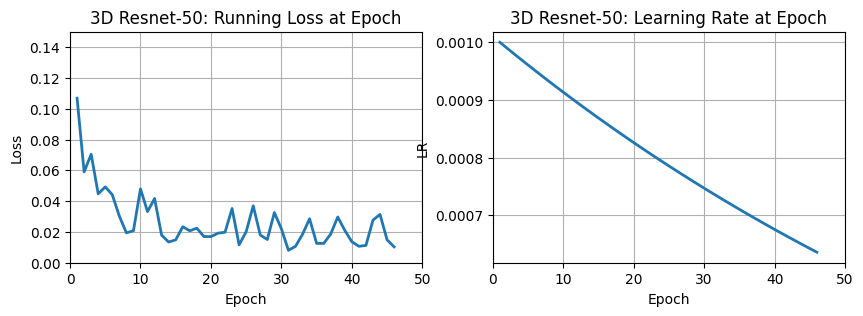

In [29]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.loss_list, linewidth=2.0)
ax[0].title.set_text("3D Resnet-{}: Running Loss at Epoch".format(proj_config.model_depth))
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 50)
ax[0].set_ylim(0, 0.15)
ax[0].grid()

ax[1].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.lr_list, linewidth=2.0)
ax[1].title.set_text("3D Resnet-{}: Learning Rate at Epoch".format(proj_config.model_depth))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("LR")
ax[1].set_xlim(0, 50)
ax[1].grid()
plt.show()

### Dataset into Dataloader
- Dataloader allow setting of batch size, which is another useful parameter for training.
- shuffle allow data change of data orders, only useful for data training.

In [30]:
data_loader = DataLoader(test_data, batch_size=proj_config.batch_size, shuffle=False, num_workers=proj_config.num_workers, pin_memory=proj_config.pin_memory)

## Inference the Model
- Med3D Resnet model requires scaling of output.
- The scaling will cause poor prediction.

In [31]:
masks = []
probs = None
outputs = None
proj_config.nn_model.eval()
for batch_id, batch_data in enumerate(data_loader):
    imgs, segs = batch_data

    if not proj_config.no_cuda:
        imgs = imgs.cuda()
    with torch.no_grad():
        probs = proj_config.nn_model(imgs.float())
        outputs = F.softmax(probs, dim=1)
        # resize mask to original size
    batchsize, _, mask_d, mask_h, mask_w = outputs.shape
    batchsize, _, depth, height, width = imgs.shape
    scale = [1, depth*1.0/mask_d, height*1.0/mask_h, width*1.0/mask_w]
    # loop through batch size
    for i, img in enumerate(imgs):
        output = outputs[i]
        print("Batch={} data={} Unique: {}".format(batch_id, i, np.unique(segs)))
        if not no_cuda:
            output = output.to('cpu')
        # scale only z, y, x
        output = ndimage.zoom(output, scale, order=1)
        # selecting armax layer to form segmentation
        output = np.argmax(output, axis=0)
        masks.append(output)

Batch=0 data=0 Unique: [0. 1. 2.]
Batch=1 data=0 Unique: [0.]
Batch=2 data=0 Unique: [0. 1. 2. 3.]
Batch=3 data=0 Unique: [0. 1. 2.]
Batch=4 data=0 Unique: [0. 1. 2.]
Batch=5 data=0 Unique: [0. 1. 2.]
Batch=6 data=0 Unique: [0. 1. 2. 3.]
Batch=7 data=0 Unique: [0. 1. 2. 3.]
Batch=8 data=0 Unique: [0. 1. 2.]
Batch=9 data=0 Unique: [0. 1. 2. 3.]


### Code for DICE score
- Below is the code for DICE socre calculation that is used by models in this Notebook.

In [32]:
def seg_eval(pred_mask, true_mask, num_classes):
    """
    calculate the dice between prediction and ground truth
    input:
        pred_mask: predicted mask
        true_mask: groud truth
        num_classes: eg. [0, 1, 2, 3]

    returns:
        dice_scores : list of floats Dice coefficients for each class.

    """
    # pred_mask = pred_mask.to('cpu')
    # true_mask = true_mask.to('cpu')
    dice_scores = []
    class_count = np.zeros(num_classes)

    # loop through each class
    for class_idx in range(num_classes):

        true_class = true_mask == class_idx
        pred_class = pred_mask == class_idx

        intersection = np.logical_and(true_class, pred_class)
        epsilon = 1e-6
        # 2* (adding the matching event) and divide by 2 * class counts (true class and pred class)
        dice_class = 2. * intersection.sum() / (true_class.sum() + pred_class.sum() + epsilon)
        if not true_class.sum() == 0:
            class_count[class_idx] += 1
        dice_scores.append(dice_class)

    return dice_scores, class_count


In [33]:
# evaluation: calculate dice scores and mean dice

number_imgs = len(masks)

# dices = np.zeros([number_imgs, proj_config.n_seg_classes])
total_dice_scores_per_class = np.zeros(proj_config.n_seg_classes)
class_counter = np.zeros(proj_config.n_seg_classes)
for idx in range(number_imgs):
    _, seg = test_data[idx]
    d_scores, class_count = seg_eval(masks[idx], seg[0], proj_config.n_seg_classes)
    total_dice_scores_per_class = total_dice_scores_per_class + d_scores
    class_counter += class_count
    if idx % 1 == 0:
        print("idx= {} dice_scores = {} and class_exist ={}".format(idx, d_scores, class_count))
print("===="*10)
print("Mean Class Dice Scores")
print(total_dice_scores_per_class/class_counter)


idx= 0 dice_scores = [0.9985004142181151, 0.6939323876664698, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 1 dice_scores = [0.9999999999999274, 0.0, 0.0, 0.0] and class_exist =[1. 0. 0. 0.]
idx= 2 dice_scores = [0.9974779960255631, 0.6694632636031241, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 3 dice_scores = [0.9978404064066213, 0.6933103441748427, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 4 dice_scores = [0.9966221452924168, 0.5930360309650674, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 5 dice_scores = [0.9948625326078573, 0.48488194161499915, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 6 dice_scores = [0.9954843915896255, 0.5249589353775165, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 7 dice_scores = [0.9826707709713769, 0.6740172416656165, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 8 dice_scores = [0.9983887290213732, 0.7325508551619618, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 9 dice_scores = [0.9896091888288675, 0.5589260037529183, 0.0, 0.0] and class_exist

### Result of Resnet50
- poor dice scores
- class 0: is the main prediction
- class 1: Kidney is the second
- class 2 and 3: no prediction is found.
- Plot has shown same story. Kidney prediction seems reasonably well.
- With Resnet50, the Kidney dice score is about 0.6.
- For future work, RCNN could be studied and employed. No further investigation could be carried out as simple UNET is believed to perform better.

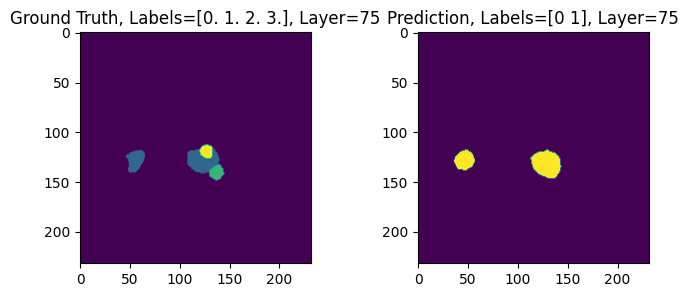

In [34]:
this_layer = 75
mask_id = 2
_, seg = test_data[mask_id]
seg = seg[0]
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].imshow(seg[this_layer,:,:])
axes[0].set_title(f"Ground Truth, Labels={np.unique(seg[this_layer,:,:])}, Layer={this_layer}")
axes[1].imshow(masks[mask_id][this_layer,:,:])
axes[1].set_title(f"Prediction, Labels={np.unique(masks[mask_id][this_layer,:,:])}, Layer={this_layer}")
plt.show()

#### Free Up Memory for Next Section

In [35]:
%reset_selective -f "^seg$"
%reset_selective -f "^imgs$"
%reset_selective -f "^segs$"
%reset_selective -f "^masks*"
%reset_selective -f "^outputs$"
%reset_selective -f "^output$"
%reset_selective -f "^training_data$"
%reset_selective -f "^test_data$"
%reset_selective -f "^probs$"
%reset_selective -f "^checkpoint$"
%reset_selective -f "^proj_config$"
%reset_selective -f "^data_loader$"
%reset_selective -f "^proj_resnet_model$"


## UNET 3D
- Popular in multiclasses segmentation due in 2D.
- Widely used in 3D Voxel Space for multiclasses segmentation.
- Paper https://arxiv.org/pdf/1606.06650.pdf has employed UNET in 3D to solve similar problem, which has 3 labels instead of 4 labels.
- General information of the work can be found at https://towardsdatascience.com/review-3d-u-net-volumetric-segmentation-medical-image-segmentation-8b592560fac1

### UNET 3D - Import

In [36]:
from classes.models.unet3d import UNet3D
from classes.epoch_results import EpochResult

### Get Train and Test Data
- Train data will not be used in this notebook. Training is done separately using <mark> Unet3D_train_vanila_model.ipynb</mark>

In [37]:
training_data = ProcessedKit23TorchDataset(train_data=True, test_size=0.25, dataset_dir = transformed_dataset_dir_path)
test_data = ProcessedKit23TorchDataset(train_data=False, test_size=0.25, dataset_dir = transformed_dataset_dir_path)

In [38]:
num_classes = 4
model = UNet3D(1, num_classes, channel_selection=1, double_conv_kernel_size=3).to(device)

### Unet 3D Vanila
- The chosen upsampling method: Transposed Convolution
- print model could further verify the model
- skip connection can be observed at the unet3d.py file at Up class
- 4 classes for the design of network

In [39]:
print_model = False
if print_model:
    print(model)

#### Load Trained Weight
- Note: Adam has been chosen as optimiser.
- The optimiser does not have weight decay.
- The chosen learning rate is an exponential learning rate, starting at 0.001.
- The following code loads the trained weights for inference.

In [40]:
train_from_pretrained = True
epoch_res = EpochResult()
epoch_start = 0
if train_from_pretrained:
    print("Unet3D - loading from trained weight")
    # this continues from certain training points
    checkpoint_ref_filepath = "training_checkpoints/Model_UNET_ch1_ks3_epoch50.pth.tar"
    # checkpoint_ref_filepath = "training_checkpoints/Model_UNET_SGD_epoch28.pth.tar"
    checkpoint_file = os.path.join(base_dir, checkpoint_ref_filepath)
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['state_dict'])
    # load additional customised info from checkpoint
    ep_list = checkpoint['epoch_list']
    loss_list = checkpoint['loss_list']
    lr_list = checkpoint['lr_list']
    epoch_res = EpochResult(_epoch_list =ep_list, _loss_list=loss_list, _lr_list=lr_list)
    epoch_start = epoch_res.epoch_list[-1] + 1
else:
    raise Exception("Only trained weight should be loaded for main notebook.")


Unet3D - loading from trained weight


#### Vanila 3D UNET
- The trainig result is obtained from the saved checkpoint from <mark>Unet3D_train_vanila_model.ipynb </mark>. Check the notebook for further details.
- Both SGD and ADAM were used to train the model. The difference in performance is not obvious, but ADAM appears to converge faster than SGD.
- Feature extraction in neural networks requires a high number of channels.
- Due to the size of the training dataset, no SGD training results will be presented.
- The 'shuffle' feature enables the rearrangement of data orders, which is beneficial for model training.

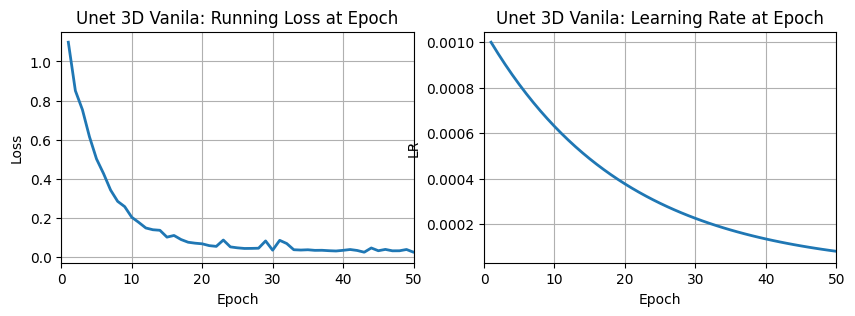

In [41]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.loss_list, linewidth=2.0)
ax[0].title.set_text("Unet 3D Vanila: Running Loss at Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 50)
ax[0].grid()

ax[1].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.lr_list, linewidth=2.0)
ax[1].title.set_text("Unet 3D Vanila: Learning Rate at Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("LR")
ax[1].set_xlim(0, 50)
ax[1].grid()
plt.show()

#### Dataset into Dataloader
- The Dataloader allows the setting of the batch size. This parameter is particularly important for model training.
- The 'shuffle' feature enables the changing of data order, which is also important for model training.

In [42]:
batch_size = 4
total_batches = math.ceil(len(training_data) / batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

#### Test Loop
- The test loop terminates at 5 batch to simplify the code run.
- With batch size of 4, there are 20 test data used to determine the dice score below.
- Removing the break point will test all the test data.

In [43]:
masks = []
model.eval()
total_dice_scores_per_class = np.zeros(num_classes)
class_counter = np.zeros(num_classes)
with torch.no_grad():
    for batch_id, (images, true_masks) in enumerate(test_loader):
        images = images.to(device)  # If using GPU
        output = model(images.float())
        # output shape is - batch size, num classes, (size of matrix - z, y, x)
        probs = F.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)

        if batch_id == 5:
            break

        for i, pred in enumerate(preds):
            pred = pred.to('cpu').numpy()
            mask = true_masks[i][0].to('cpu').numpy()
            d_scores, class_count = seg_eval(pred, mask, num_classes)
            total_dice_scores_per_class = total_dice_scores_per_class + d_scores
            class_counter += class_count
            if batch_id % 2 == 0:
                print("idx= {} dice_scores = {} and class_exist ={}".format(i, d_scores, class_count))

    print("===="*10)
    print("Mean Class Dice Scores")
    print(total_dice_scores_per_class/class_counter)


idx= 0 dice_scores = [0.9979939561744101, 0.5607344506334213, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 1 dice_scores = [0.9982750110531182, 0.8478742798286981, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 2 dice_scores = [0.9994191021883841, 0.9090617224374742, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 3 dice_scores = [0.9845629998105522, 0.5367900349950616, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 0 dice_scores = [0.9992512692797071, 0.0, 0.0, 0.0] and class_exist =[1. 0. 1. 0.]
idx= 1 dice_scores = [0.9993709041903153, 0.9355974876395414, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 2 dice_scores = [0.9989574032803266, 0.8269996133721431, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 3 dice_scores = [0.9999997822763738, 0.0, 0.0, 0.0] and class_exist =[1. 0. 0. 0.]
idx= 0 dice_scores = [0.9983418619761082, 0.6982376311542107, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 1 dice_scores = [0.984755354777918, 0.7118087146578882, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
i

#### Result of UNET 3D Vanila
- Channel selector 1, with channels (8, 16, 32, 64, 128) and a kernel size of 3, can effectively segment the kidney. However, it is unable to successfully predict features for tumors and cysts.
- The dice score for the kidney segmentation is significantly better than that of ResNet50.
- The computation is generally faster compared to ResNet.
- For classes 2 and 3, no predictions were found.

#### Free Up Memory for Next Section

In [44]:
%reset_selective -f "^masks$"
%reset_selective -f "^model$"
torch.cuda.empty_cache()



### Trilinear UpSampling 3D UNET
- instead of Transposed Convolution or ConvTranspose3d, nn.Upsample is also experimented.
- The chosen upsampling method: Upsample with trilinear mode/ scalar_factor = (2, 2, 2)
- The nn.Upsample requires additional Conv3D to match channels at the layer. See unet3d.py - Up class - for code implementation.

In [45]:
num_classes = 4
model = UNet3D(1, num_classes, channel_selection=1, double_conv_kernel_size=3, is_upsampling = True).to(device)

#### Load Trained Weight
- Note: Adam has been chosen as optimiser.
- The optimiser does not have weight decay.
- The chosen learning rate is an exponential learning rate, starting at 0.001.
- The following code loads the trained weights for inference.

In [46]:
train_from_pretrained = True
epoch_res = EpochResult()
epoch_start = 0
if train_from_pretrained:
    print("Unet3D - loading from trained weight")
    # this continues from certain training points
    checkpoint_ref_filepath = "training_checkpoints/Model_UNET_ch1_ks3_up_epoch35.pth.tar"
    checkpoint_file = os.path.join(base_dir, checkpoint_ref_filepath)
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['state_dict'])
    # load additional customised info from checkpoint
    ep_list = checkpoint['epoch_list']
    loss_list = checkpoint['loss_list']
    lr_list = checkpoint['lr_list']
    epoch_res = EpochResult(_epoch_list =ep_list, _loss_list=loss_list, _lr_list=lr_list)
    epoch_start = epoch_res.epoch_list[-1] + 1
else:
    raise Exception("Only trained weight should be loaded for main notebook.")


Unet3D - loading from trained weight


#### Trilinear Upsampling for 3D UNET
- Implementation of upsampling method has been investigated.
- See file provided at <mark>clesses/models/unet3d.py</mark> for more infomation.
- Loss against epoch is plotted. Loss is deemed relatively high when comparing the model to the Vanila model.

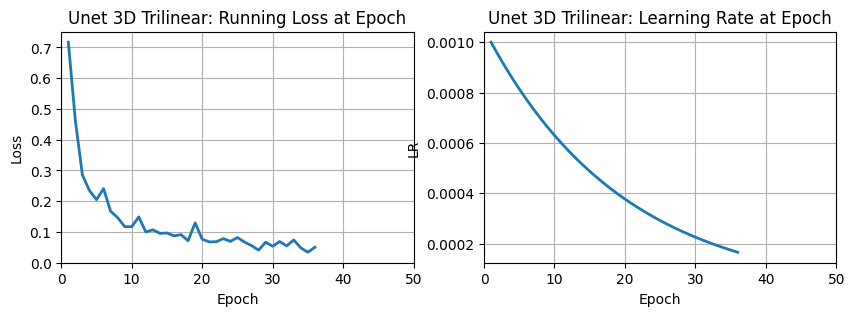

In [47]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.loss_list, linewidth=2.0)
ax[0].title.set_text("Unet 3D Trilinear: Running Loss at Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 50)
ax[0].grid()

ax[1].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.lr_list, linewidth=2.0)
ax[1].title.set_text("Unet 3D Trilinear: Learning Rate at Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("LR")
ax[1].set_xlim(0, 50)
ax[1].grid()
plt.show()

#### Dataset into Dataloader
- The Dataloader allows the setting of the batch size. This parameter is particularly important for model training.
- The 'shuffle' feature enables the changing of data order, which is also important for model training.

In [48]:
batch_size = 4
total_batches = math.ceil(len(training_data) / batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

#### Test Loop
- The test loop terminates at 5 batch to simplify the code run.
- With batch size of 4, there are 20 test data used to determine the dice score below.
- Removing the break point will test all the test data.

In [49]:
masks = []
model.eval()
total_dice_scores_per_class = np.zeros(num_classes)
class_counter = np.zeros(num_classes)
with torch.no_grad():
    for batch_id, (images, true_masks) in enumerate(test_loader):
        images = images.to(device)  # If using GPU
        output = model(images.float())
        # output shape is - batch size, num classes, (size of matrix - z, y, x)
        probs = F.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)

        if batch_id == 5:
            break

        for i, pred in enumerate(preds):
            pred = pred.to('cpu').numpy()
            mask = true_masks[i][0].to('cpu').numpy()
            d_scores, class_count = seg_eval(pred, mask, num_classes)
            total_dice_scores_per_class = total_dice_scores_per_class + d_scores
            class_counter += class_count
            if batch_id % 2 == 0:
                print("idx= {} dice_scores = {} and class_exist ={}".format(i, d_scores, class_count))

    print("===="*10)
    print("Mean Class Dice Scores")
    print(total_dice_scores_per_class/class_counter)

idx= 0 dice_scores = [0.9934185861604031, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 1 dice_scores = [0.9929914728050323, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 2 dice_scores = [0.9971690051109728, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 3 dice_scores = [0.9797606918610813, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 0 dice_scores = [0.9992512692797071, 0.0, 0.0, 0.0] and class_exist =[1. 0. 1. 0.]
idx= 1 dice_scores = [0.9945913185718838, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 2 dice_scores = [0.9972201656866982, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 3 dice_scores = [0.9999999999999274, 0.0, 0.0, 0.0] and class_exist =[1. 0. 0. 0.]
idx= 0 dice_scores = [0.9928228376284063, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 1 dice_scores = [0.9797124182734789, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 2 dice_scores = [0.9962803436305285, 0.0, 0.0, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 3 dice_scores = [0.98846274

#### Result of Trilinear UpSampling UNET channel selector 1
- The dice score for kidney has vanished.
- class 1, 2 and 3: no prediction is found.

### Discussion for Next Strategy for improvement
- Information from https://towardsdatascience.com/review-3d-u-net-volumetric-segmentation-medical-image-segmentation-8b592560fac1 has used higher feature channels number.
- To extract more features, kernel size may also requires to be increased.
- Adding attention to the 3D Unet may also help to extract the features to the output.

#### Free Up Memory for Next Section

In [50]:
%reset_selective -f "^masks$"
%reset_selective -f "^model$"
torch.cuda.empty_cache()



### UNET 3D - More Channels and Kernel Size 5
- It is believed that features fail to captured due to channels number and convolution kernel size.
- With some training done by using notebook <mark> Unet3D_training_train_vanila_model.ipynb</mark>
- channel selector 2: (16, 32, 64, 128, 256) and kernel size 5 is chosen.

In [51]:
num_classes = 4
model = UNet3D(1, num_classes, channel_selection=2, double_conv_kernel_size=5).to(device)

#### Load Trained Weight
- Note: Adam has been chosen as optimiser.
- The optimiser does not have weight decay.
- The chosen learning rate is an exponential learning rate, starting at 0.001.
- The following code loads the trained weights for inference.

In [52]:
train_from_pretrained = True
epoch_res = EpochResult()
epoch_start = 0
if train_from_pretrained:
    print("Unet3D - loading from trained weight")
    # this continues from certain training points
    checkpoint_ref_filepath = "training_checkpoints/Model_UNET_ch2_ks5_epoch45.pth.tar"
    checkpoint_file = os.path.join(base_dir, checkpoint_ref_filepath)
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['state_dict'])
    # load additional customised info from checkpoint
    ep_list = checkpoint['epoch_list']
    loss_list = checkpoint['loss_list']
    lr_list = checkpoint['lr_list']
    epoch_res = EpochResult(_epoch_list =ep_list, _loss_list=loss_list, _lr_list=lr_list)
    epoch_start = epoch_res.epoch_list[-1] + 1
else:
    raise Exception("Only trained weight should be loaded for main notebook.")


Unet3D - loading from trained weight


#### Tuned Vanila 3D UNET
- The trainig result is obtained from the saved checkpoint from <mark>Unet3D_train_vanila_model.ipynb </mark>. Check the notebook for further details.
- To offer improved features extraction capability, kernel size has been increased from 3 to 5.
- Also, channels number for features extraction has also been doubled.
- This caused significant increase of GPU RAM and CPU RAM requirement.
- Batch size cut down to 1 with the model setup when GPU Tesla T4 is used at Google Colab.

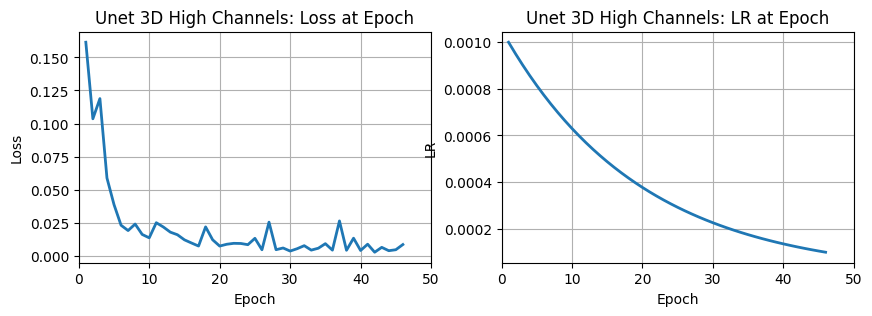

In [53]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.loss_list, linewidth=2.0)
ax[0].title.set_text("Unet 3D High Channels: Loss at Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 50)
ax[0].grid()

ax[1].plot(np.array(epoch_res.epoch_list) + 1, epoch_res.lr_list, linewidth=2.0)
ax[1].title.set_text("Unet 3D High Channels: LR at Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("LR")
ax[1].set_xlim(0, 50)
ax[1].grid()
plt.show()

#### Dataset into Dataloader
- The Dataloader allows the setting of the batch size. This parameter is particularly important for model training.
- The 'shuffle' feature enables the changing of data order, which is also important for model training.
- The batch size has to be reduced when comparing to the model that has less feature channels.

In [54]:
batch_size = 2
total_batches = math.ceil(len(training_data) / batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

#### Test Loop
- The test loop terminates at 10th batch to simplify the code run.
- With batch size of 2, there are 20 test data used to determine the dice score below.
- Removing the break point will test all the test data.

In [55]:
masks = []
model.eval()
total_dice_scores_per_class = np.zeros(num_classes)
class_counter = np.zeros(num_classes)
with torch.no_grad():
    for batch_id, (images, true_masks) in enumerate(test_loader):
        images = images.to(device)  # If using GPU
        output = model(images.float())
        # output shape is - batch size, num classes, (size of matrix - z, y, x)
        probs = F.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)

        if batch_id == 10:
            break

        for i, pred in enumerate(preds):
            pred = pred.to('cpu').numpy()
            mask = true_masks[i][0].to('cpu').numpy()
            masks.append(pred)
            d_scores, class_count = seg_eval(pred, mask, num_classes)
            total_dice_scores_per_class = total_dice_scores_per_class + d_scores
            class_counter += class_count
            if batch_id % 2 == 0:
                print("idx= {} dice_scores = {} and class_exist ={}".format(i, d_scores, class_count))

    print("===="*10)
    print("Mean Class Dice Scores")
    print(total_dice_scores_per_class/class_counter)


idx= 0 dice_scores = [0.9977267045671049, 0.13216902539130446, 0.48958553025224544, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 1 dice_scores = [0.9974779608225257, 0.5390093936760119, 0.2019979699748705, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 0 dice_scores = [0.9994777832053965, 0.9141077127386729, 0.27920865991300126, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 1 dice_scores = [0.9999999999999274, 0.0, 0.0, 0.0] and class_exist =[1. 0. 0. 0.]
idx= 0 dice_scores = [0.9992512692797071, 0.0, 0.0, 0.0] and class_exist =[1. 0. 1. 0.]
idx= 1 dice_scores = [0.998341708797408, 0.7616180620824583, 0.025800381310179008, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 0 dice_scores = [0.9983843876225856, 0.5420834290763044, 0.10574042264000039, 0.0] and class_exist =[1. 1. 1. 1.]
idx= 1 dice_scores = [0.9993371204137665, 0.5976217792629701, 0.13830517785701815, 0.0] and class_exist =[1. 1. 1. 0.]
idx= 0 dice_scores = [0.9983510178981119, 0.6340265452079745, 0.6771406864014976, 0.0] and class_exist =[1. 1.

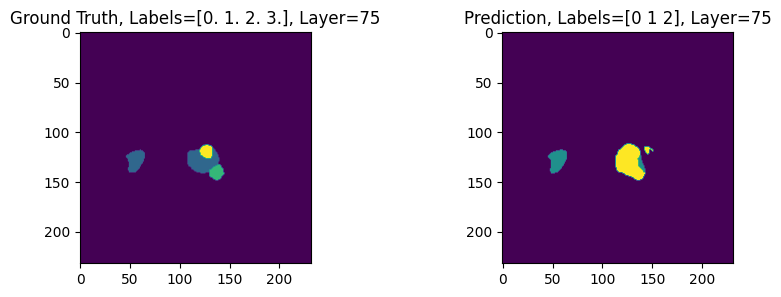

In [56]:
this_layer = 75
mask_id = 12
_, seg = test_data[mask_id]
seg = seg[0]
len(masks)
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(10,3))
axes[0].imshow(seg[this_layer,:,:])
axes[0].set_title(f"Ground Truth, Labels={np.unique(seg[this_layer,:,:])}, Layer={this_layer}")
axes[1].imshow(masks[mask_id][this_layer,:,:])
axes[1].set_title(f"Prediction, Labels={np.unique(masks[mask_id][this_layer,:,:])}, Layer={this_layer}")
plt.show()

#### Result of UNET 3D with More Channels and Kernel Size 5
- Channel selector 2, with channels (16, 32, 64, 128, 256) and a kernel size of 5, effectively segments the kidney and can also predict tumors. However, it still cannot extract features of cysts.
- The dice score for kidney segmentation is approximately 0.65.
- The dice score for tumor segmentation is approximately 0.24.
- For class 3, which represents cysts, no successful predictions have been made.


# Conclusion
- The final customized UNet 3D model successfully detects class labels 0, 1, and 2, which correspond to the background, kidney, and tumor, with dice scores of 0.99, 0.65, and 0.24, respectively.
- The final trained model failed to detect cysts, indicating that significant work is still required to meet this challenge.
- Due to GPU limitations, feature extraction cannot be easily enhanced with further increases in feature channels and kernel size.
- Similarly, increasing the resolution of the dataset may be challenging. However, aggressive downsampling of the dataset should be avoided to effectively tackle this challenge

# Future Work
- Future work may include adding attention mechanisms to the model to observe their effectiveness in detecting cysts.
- Alternative methods may be worth investigating, such as introducing RCNN into medical 3D imaging.
- With access to improved hardware resources in the future, potential work includes overcoming existing constraints to enable a more comprehensive exploration of hyperparameters, and process with original dataset. 
- The improvement of model architectures may entail increasing channels or incorporating fully-layered convolution to safeguard intricate semantic information.

In [57]:
# %reset_selective -f "^train_loader$"
# %reset_selective -f "^img$"
# %reset_selective -f "^loss$"


In [58]:
# torch.cuda.empty_cache()